In [307]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('/Users/dmitrys/anaconda2/lib/python2.7/site-packages')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
import seaborn as sns
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [308]:
def plot_confusion(predictions, title):
    array = confusion_matrix(yval, predictions)
    df_cm = pd.DataFrame(array)
    plt.figure(figsize = (3,3))
    sns.heatmap(df_cm, annot=True, fmt='g', cbar=False)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title(title);
    
    
def plot_roc_curve(predictions):
    try:
        preds = predictions[:,1]
    except:
        preds = predictions
    fpr, tpr, threshold = roc_curve(yval, preds)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [469]:
train = pd.read_csv("traindata.csv", index_col=0)
test = pd.read_csv("testdata.csv", index_col=0)
submission = pd.read_csv("sample_submission.csv", index_col=0)

In [470]:
counts = [[], [], [], []]

for c in train.columns:
    typ = train[c].dtype
    uniq = len(np.unique(train[c]))
    if uniq == 1: counts[0].append(c)
    elif uniq == 2 and typ == np.int64: counts[1].append(c)
    elif typ == np.int64: counts[2].append(c)
    else: counts[3].append(c)

print('Constant features: {} Binary features: {} Numerical features: {} Categorical features: {}\n'.format(*[len(c) for c in counts]))

Constant features: 0 Binary features: 1 Numerical features: 7 Categorical features: 9



In [471]:
counts[2]

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [472]:
for i in counts[3]:
    train[i] = le.fit_transform(train[i])
    test[i] = le.transform(test[i])

In [473]:
train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
1,44,7,0,1,0,51,1,1,2,27,8,3094,2,-1,0,3,1
2,34,4,1,2,0,1036,1,0,0,19,9,54,7,-1,0,3,0
3,32,4,2,3,0,3044,1,0,2,2,6,651,1,-1,0,3,0
4,36,9,1,1,0,3579,0,0,0,14,1,308,2,-1,0,3,0
5,55,0,1,1,0,1662,0,0,0,4,6,94,2,-1,0,3,1


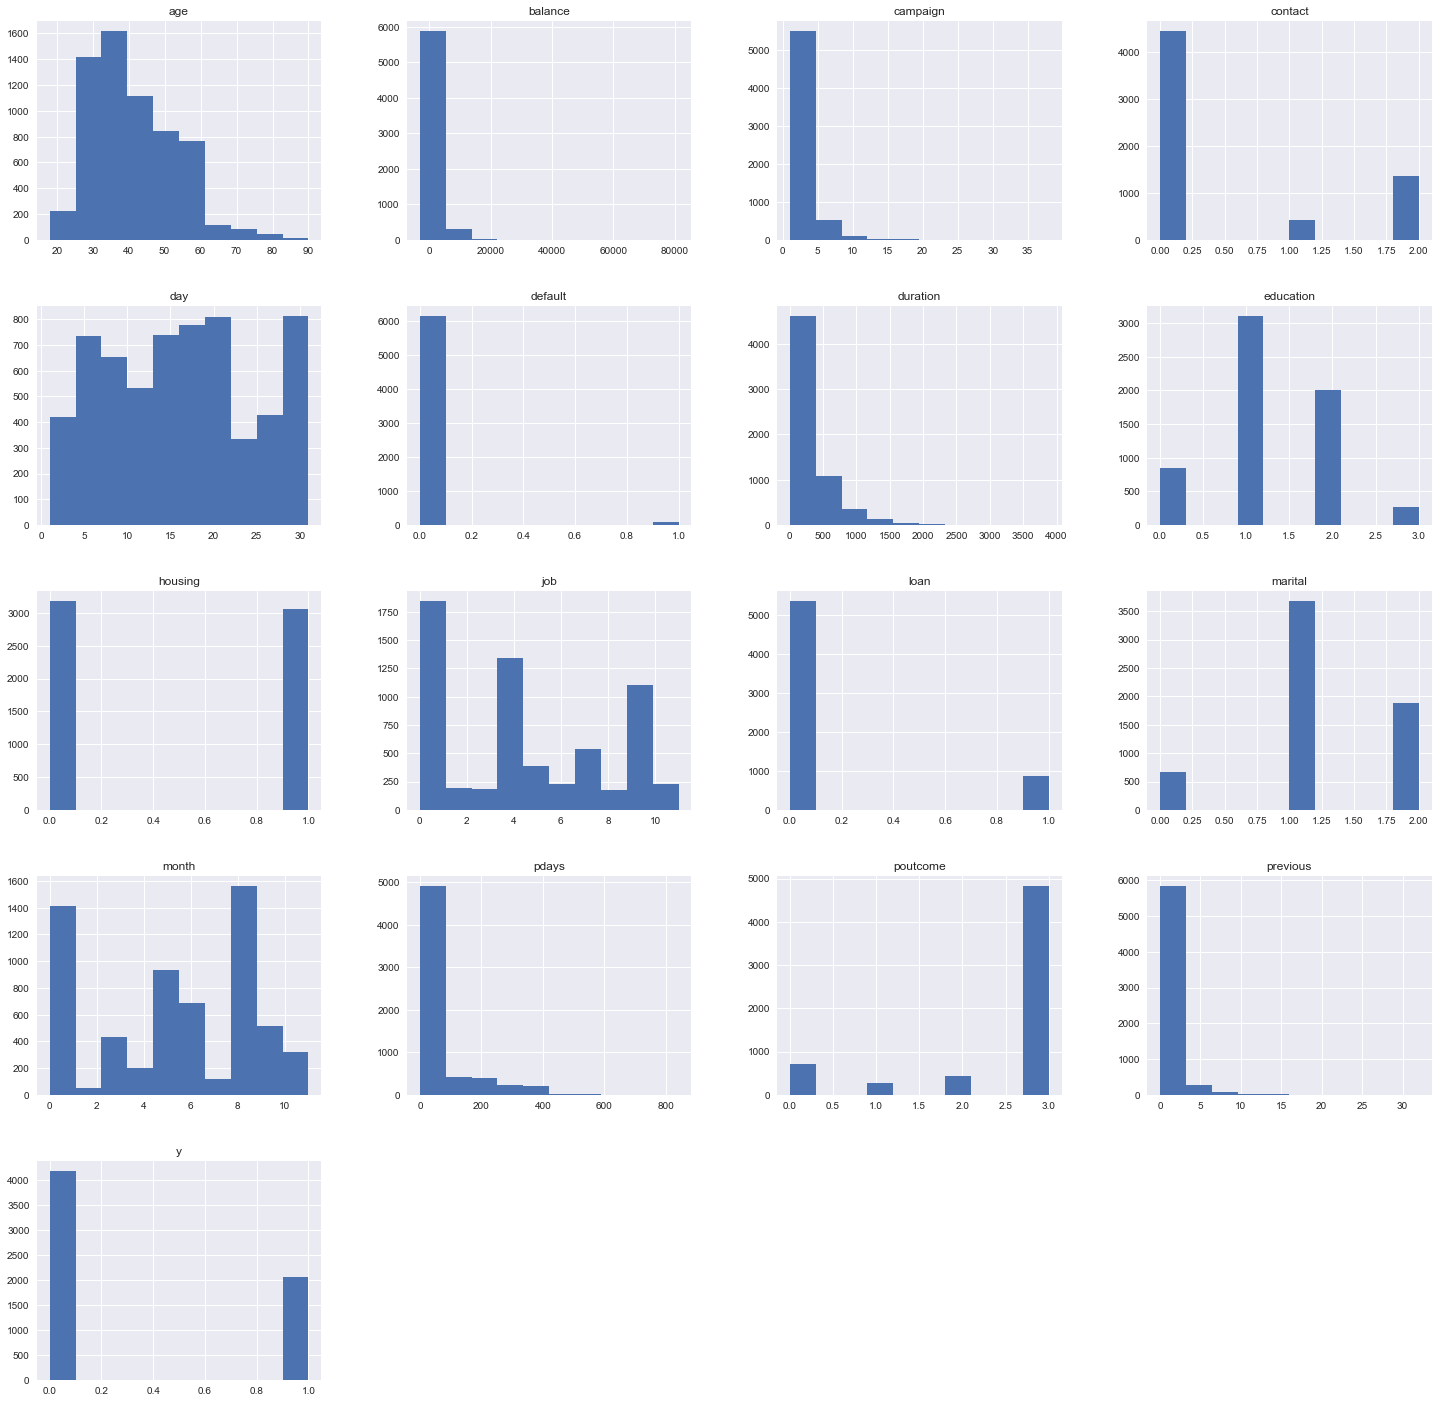

In [474]:
train.hist(figsize=(25, 25));

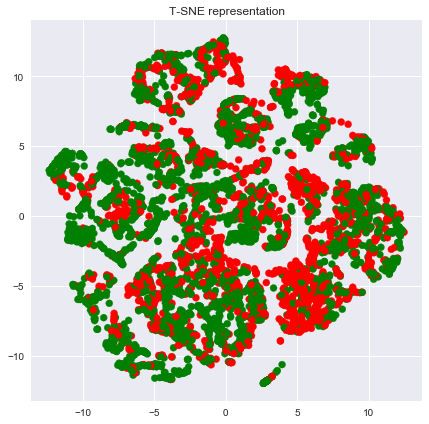

In [296]:
from sklearn.manifold import TSNE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train)
tsne = TSNE(n_components=2)
tsne_representation = tsne.fit_transform(X_scaled)

plt.figure(figsize=(7,7))
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=y.map({0: 'green', 1: 'red'}))
plt.title("T-SNE representation");

In [468]:
# train["tsne_1"] = tsne_representation[:,0]
# train["tsne_2"] = tsne_representation[:,1]

In [316]:
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score

In [475]:
y = train.y
X = train.drop(["y"], axis=1)

In [476]:
Xtr, Xval, ytr, yval  = train_test_split(X, y, test_size=0.30, random_state=42) # 30% для отложенной выборки

In [477]:
Xtr.shape, Xval.shape

((4368, 16), (1872, 16))

In [528]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures()
Xtr_poly = pf.fit_transform(Xtr)
Xval_poly = pf.transform(Xval)



Xtr_scaled = np.concatenate([scaler.fit_transform(Xtr[counts[2]]), 
                                                  Xtr.drop(counts[2], 
                                                           axis=1)], 
                             axis=1)

Xval_scaled = np.concatenate([scaler.transform(Xval[counts[2]]), 
                                                  Xval.drop(counts[2], 
                                                           axis=1)],
                             axis=1)
                             
lr = LogisticRegression(class_weight="balanced") # используем l1, чтобы убирать наименее важные признаки
lr.fit(Xtr_scaled, ytr)

print('Train auc {}'.format(roc_auc_score(ytr, lr.predict_proba(Xtr_scaled)[:,1])))
print('Validation auc {}'.format(roc_auc_score(yval, lr.predict_proba(Xval_scaled)[:,1])))

Train auc 0.879026944571
Validation auc 0.866492798734


In [485]:
def importance(model):
    
    ### возвращает отсортированные по абсолютному значению коэффициенты
    
    coefs = pd.DataFrame(model.coef_.T, index=Xtr.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    return coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

In [486]:
def visualize_coefficients(classifier, feature_names, n_top_features=10):
    
    ### визулизирует влияние факторов на целевую переменную
    
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])

    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

In [487]:
importance(lr).head(30)

,coef
education,1.810800
duration,-1.058684
campaign,-0.765036
pdays,-0.685199
default,-0.515352
balance,0.424790
poutcome,0.329893
housing,0.258618
day,0.250803
contact,0.221469


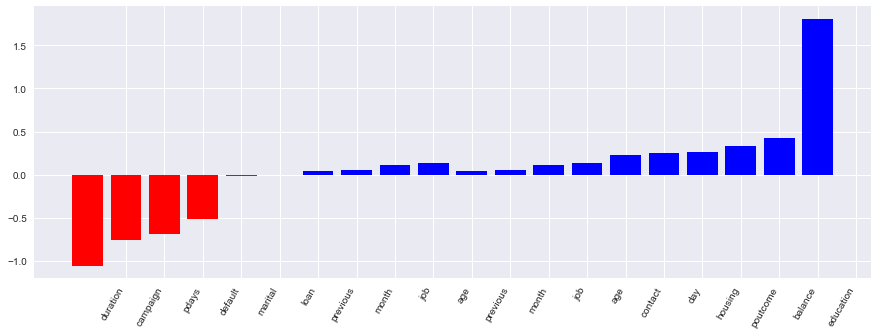

In [488]:
visualize_coefficients(lr, Xtr.columns)

In [489]:
from sklearn.model_selection import GridSearchCV
Cs = 10**np.linspace(-1, 7, num=15)
grid = {'C': Cs}
gridsearch = GridSearchCV(LogisticRegression(penalty="l1"), grid, scoring='roc_auc', cv=5)
%time gridsearch.fit(X, y)

CPU times: user 8.65 s, sys: 1.64 s, total: 10.3 s
Wall time: 5.6 s


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-01,   3.72759e-01,   1.38950e+00,   5.17947e+00,
         1.93070e+01,   7.19686e+01,   2.68270e+02,   1.00000e+03,
         3.72759e+03,   1.38950e+04,   5.17947e+04,   1.93070e+05,
         7.19686e+05,   2.68270e+06,   1.00000e+07])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

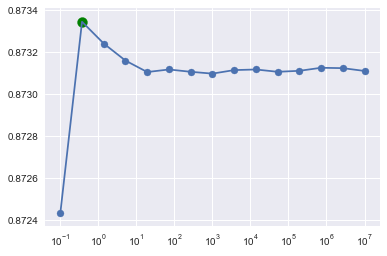

In [490]:
scores = [x.mean_validation_score for x in  gridsearch.grid_scores_]
plt.plot(Cs, scores)
plt.scatter(Cs, scores)
plt.scatter(Cs[np.argmax(scores)], scores[np.argmax(scores)], c='g', s=100)
plt.xscale('log')

In [491]:
lr = LogisticRegression(class_weight="balanced", C=Cs[np.argmax(scores)]) # используем l1, чтобы убирать наименее важные признаки
lr.fit(Xtr_scaled, ytr)

LogisticRegression(C=0.37275937203149401, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

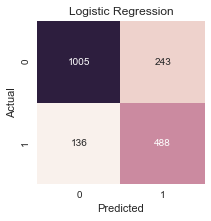

In [492]:
plot_confusion(lr.predict(Xval_scaled), "Logistic Regression")

In [493]:
print(classification_report(lr.predict(Xval_scaled), yval))

             precision    recall  f1-score   support

          0       0.81      0.88      0.84      1141
          1       0.78      0.67      0.72       731

avg / total       0.80      0.80      0.79      1872



In [494]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")

In [330]:
rf_params_dist_grid = {
    'max_depth': np.arange(16, 30, 5),
    'max_features': np.linspace(0.3, 0.5, 2),
}
rf_params_fixed = {
    'random_state': 7,
    'n_estimators': 500,
    'n_jobs': -1
    
}

In [331]:
skf = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)

In [332]:
rf_grid = GridSearchCV(
    n_jobs=-1,
    estimator = RandomForestClassifier(**rf_params_fixed),
    param_grid= rf_params_dist_grid,
    cv = skf,
    scoring='roc_auc',
    verbose=True
)

In [333]:
%%time
rf_grid.fit(Xtr, ytr)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.2min finished


CPU times: user 6.94 s, sys: 357 ms, total: 7.3 s
Wall time: 1min 13s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False, random_state=7,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': array([ 0.3,  0.5]), 'max_depth': array([16, 21, 26])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=True)

In [334]:
rf_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=21, max_features=0.29999999999999999,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=7, verbose=0, warm_start=False)

In [335]:
from sklearn.learning_curve import validation_curve,learning_curve
def plot_with_std(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)
        
def plot_learning_curve(clf, X, y, scoring, cv=5):
 
    train_sizes = np.linspace(0.05, 1, 20)
    n_train, val_train, val_test = learning_curve(clf,
                                                  X, y, train_sizes, cv=cv,
                                                  scoring=scoring, n_jobs = -1)
    plot_with_std(n_train, val_train, label='training scores', c='green')
    plot_with_std(n_train, val_test, label='validation scores', c='red')
    plt.xlabel('Training Set Size'); plt.ylabel(scoring)
    plt.legend()

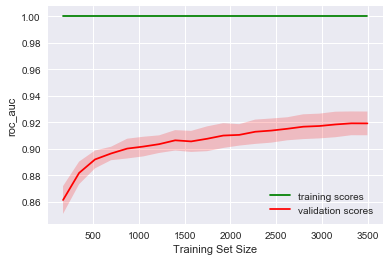

In [336]:
plot_learning_curve(rf_grid.best_estimator_,Xtr, ytr, scoring='roc_auc', cv=5)

In [337]:
print('Roc auc: {}'.format(round(rf_grid.best_score_, 3)))

Roc auc: 0.92


In [495]:
rfc = RandomForestClassifier(random_state=42, oob_score=True, n_estimators=500, n_jobs=-1, **rf_grid.best_params_)
rfc.fit(Xtr, ytr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=21, max_features=0.29999999999999999,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

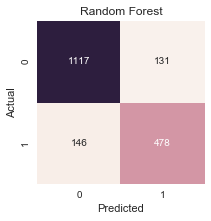

In [496]:
plot_confusion(rfc.predict(Xval), "Random Forest")

In [497]:
print(classification_report(rfc.predict(Xval), yval))

             precision    recall  f1-score   support

          0       0.90      0.88      0.89      1263
          1       0.77      0.78      0.78       609

avg / total       0.85      0.85      0.85      1872



# kNN

In [498]:
from sklearn.neighbors import KNeighborsClassifier
# fit a k-nearest neighbor model to the data
quality = []
for i in range(30):
    model_kNN = KNeighborsClassifier(n_neighbors=i+1)
    model_kNN.fit(Xtr_scaled, ytr)
    # make predictions
    expected = yval
    predicted = model_kNN.predict_proba(Xval_scaled)
    # summarize the fit of the model
    quality.append(roc_auc_score(expected, predicted[:,1]))

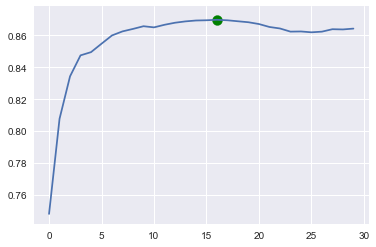

In [499]:
plt.plot(quality)
plt.scatter(list(range(30))[np.argmax(quality)], quality[np.argmax(quality)], c='g', s=100)

In [501]:
model_kNN = KNeighborsClassifier(n_neighbors=list(range(30))[np.argmax(quality)]+1)
model_kNN.fit(Xtr_scaled, ytr)
expected = yval
predicted = model_kNN.predict_proba(Xval_scaled)
roc_auc_score(expected, predicted[:,1])

0.86984174679487181

# Naive Bayes

In [502]:
from sklearn.naive_bayes import GaussianNB
model_B = GaussianNB()
model_B.fit(Xtr_scaled, ytr)
print(model_B)
# make predictions
expected = yval
predicted = model_B.predict_proba(Xval_scaled)
# summarize the fit of the model
roc_auc_score(expected, predicted[:,1])

GaussianNB(priors=None)


0.81082937828731105

# XGB

In [503]:
import sys
sys.path.append('/Users/dmitrys/xgboost/python-package/')

In [504]:
import xgboost as xgb

In [505]:
y.value_counts()/len(y)

0    0.669071
1    0.330929
Name: y, dtype: float64

In [506]:
weights = y.copy()
weights[y==1] = 0.669071
weights[y==0] = 0.01

In [598]:
dtrain = xgb.DMatrix(X, label=y)

params = {
    'objective': 'binary:logistic',
    'weight':weights,
    'max_depth': 50,
    'eta': 0.01,
    'subsample': 1,
    'gamma':0.8,
    'colsample_bytree':0.7,
}
trees = 1500

cv = xgb.cv(params, dtrain, metrics=('auc'), verbose_eval=False, nfold=7, show_stdv=False, num_boost_round=trees)

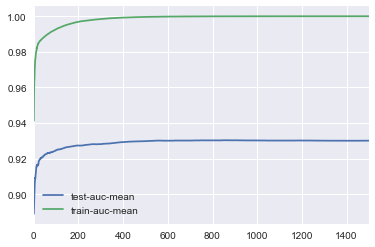

In [599]:
cv.plot(y=['test-auc-mean', 'train-auc-mean'])

In [600]:
cv.loc[cv['test-auc-mean'].argmax()]

test-auc-mean     0.930335
test-auc-std      0.008132
train-auc-mean    0.999955
train-auc-std     0.000011
Name: 851, dtype: float64

In [601]:
dtrain = xgb.DMatrix(Xtr, label=ytr)

In [602]:
bst = xgb.train(params, dtrain, num_boost_round=cv['test-auc-mean'].argmax())

In [603]:
imps = pd.Series(bst.get_fscore()).sort_values()

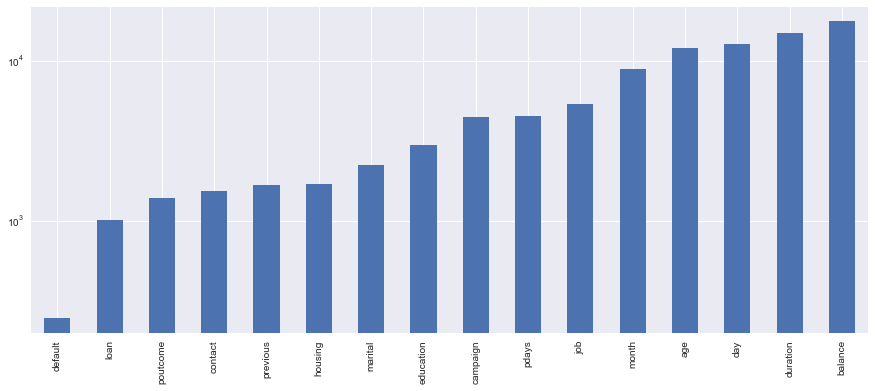

In [604]:
imps.plot(kind='bar', figsize=(15,6),logy=True)

In [605]:
dval = xgb.DMatrix(Xval)

In [606]:
xgb_prediction = bst.predict(dval)

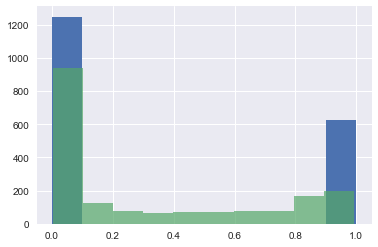

In [607]:
plt.hist(yval)
plt.hist(xgb_prediction, alpha=0.7);

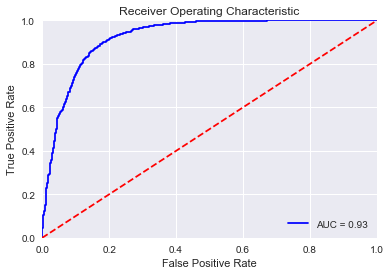

In [608]:
plot_roc_curve(xgb_prediction)

In [609]:
from scipy.optimize import minimize
from sklearn.metrics import log_loss
def ensemble_auc(w):
    return log_loss(yval, (Ps*w).sum(1).T/np.sum(w))

In [610]:
clf_1 = lr.predict_proba(Xval_scaled)[:, 1]
clf_2 = bst.predict(dval)
clf_3 = rfc.predict_proba(Xval)[:, 1]
clf_4 = model_kNN.predict_proba(Xval_scaled)[:, 1]

classifiers = [clf_1, 
               clf_2, 
               clf_3, 
               clf_4]

Ps = np.array(classifiers).T
good_classifiers = [0, 0, 0, 0]
opt = minimize(ensemble_auc, x0=np.ones(len(classifiers)))
w = opt.x/opt.x.sum()

In [611]:
def optimal(values):
    global good_classifiers
    optimal_classifiers = []
    for i in range(len(values)):
        if values[i] > 0:  
            print("Model", i+1, "is good")
            optimal_classifiers.append(classifiers[i])
    return optimal_classifiers
def full_negative_elimination(weights):
    global classifiers, Ps
    while sum(weights<0) > 0:
        opt = minimize(ensemble_auc, x0=np.ones(len(classifiers)))
        print("Function result:", opt.fun)
        classifiers = optimal(opt.x)
        Ps = np.array(classifiers).T
        weights = opt.x/opt.x.sum()
        print("Current weights:", weights)
        print('=======')
    return weights

w = full_negative_elimination(w)

('Function result:', 0.3262302329846949)
('Model', 2, 'is good')
('Model', 3, 'is good')
('Model', 4, 'is good')
('Current weights:', array([-0.06884781,  0.62136389,  0.42920335,  0.01828058]))
('Function result:', 0.3274142167463127)
('Model', 1, 'is good')
('Model', 2, 'is good')
('Model', 3, 'is good')
('Current weights:', array([ 0.66264607,  0.32479676,  0.01255717]))


In [612]:
ensebmle_reg_validation = np.zeros(len(clf_1))
for i in range(len(classifiers)):
    ensebmle_reg_validation += np.array(classifiers[i]) * w[i]
#ensebmle_reg_validation = np.log(ensebmle_reg_validation+1)
ensebmle_reg_validation[ensebmle_reg_validation<0] = 0
models  = [clf_1, 
           clf_2, 
           clf_3, 
           clf_4]

for model in range(len(models)-1):
    for classifier in classifiers:
        if sum(models[model] == classifier):
            good_classifiers[model] = 1

In [613]:
predictions = pd.DataFrame([
           clf_1, 
           clf_2,
           clf_3,
           clf_4,
           ensebmle_reg_validation,
           yval]).T
predictions.columns = ["logit", "xgb", "forest", "knn",  "ensebmle", "yval"]

In [614]:
for column in predictions:
    if column!="yval":
        print roc_auc_score(yval, predictions[column].values)

0.866492798734
0.925040320924
0.921051246096
0.869841746795
0.925564236111


In [615]:
w

array([ 0.66264607,  0.32479676,  0.01255717])

In [616]:
xgb_pred = bst.predict(xgb.DMatrix(test))
forest_pred = rfc.predict(test)
knn_pred = model_kNN.predict(scaler.transform(test))

In [617]:
final_pred = w[0] * xgb_pred + w[1] * forest_pred + w[2] * knn_pred

(array([ 859.,  122.,   66.,   25.,   32.,   24.,   60.,  103.,  239.,  586.]),
 array([ 0.00105605,  0.09925638,  0.19745672,  0.29565706,  0.3938574 ,
         0.49205774,  0.59025807,  0.68845841,  0.78665875,  0.88485909,
         0.98305943]),
 <a list of 10 Patch objects>)

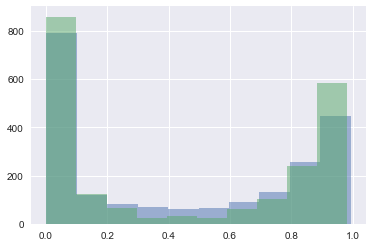

In [624]:
plt.hist(xgb_pred, alpha=0.5)
plt.hist(final_pred, alpha=0.5)

In [625]:
test_predictions = submission.copy()
test_predictions["y"] = final_pred

In [628]:
test_predictions.to_csv("predictions.csv")

In [549]:
final_pred

array([ 0.88489054,  0.75608416,  0.00384686, ...,  0.8494346 ,
        0.63925882,  0.02191218])

In [626]:
final_pred

array([ 0.89205392,  0.73091479,  0.00531802, ...,  0.72656964,
        0.67085662,  0.03235197])